## Set Up

We start by importing all required packages. (For some reason running this cell on my laptop often gives an error at first then runs fine the second time.)

In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install ucimlrepo
!{sys.executable} -m pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import *
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [2]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


Next we split our data into a training and test set. 

In [3]:
# split into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [4]:
y_train

,income
45492,<=50K.
40885,<=50K.
35713,<=50K.
26124,>50K
15819,<=50K
...,...
25544,<=50K
48056,>50K.
11513,>50K
1688,<=50K


Unfortunately we see an inconsistency in the dataset, where the same income is either labelled as <=50K or <=50K. We can see below that this splits the same group into subgroups which is not helpful.

In [5]:
y_train['income'].value_counts()

income
<=50K     19773
<=50K.     9982
>50K       6288
>50K.      3030
Name: count, dtype: int64

To fix this we first locate the rows which have a full stop at the end. 

In [6]:
r1 = y_train.loc[y_train["income"] == "<=50K."]
r2 = y_train.loc[y_train["income"] == ">50K."]
r1.head()

,income
45492,<=50K.
40885,<=50K.
35713,<=50K.
34142,<=50K.
35555,<=50K.


Then we edit those rows to fix their values. 

In [7]:
r1 = r1.index.values
r2 = r2.index.values
r1

array([45492, 40885, 35713, ..., 39829, 43883, 39168])

In [8]:
y_train.loc[r1] = "<=50K"
y_train.loc[r2] = ">50K"
y_train['income'].value_counts()

income
<=50K    29755
>50K      9318
Name: count, dtype: int64

We can now see the y values have been fixed.

## Exploratory Data Analysis

In [9]:
X_train.describe(include = 'all') 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
count,39073.000000,38310,3.907300e+04,39073,39073.000000,39073,38308,39073,39073,39073,39073.000000,39073.000000,39073.000000,38857
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,41
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States
freq,NaN,27218,NaN,12638,NaN,17893,4922,15761,33413,26125,NaN,NaN,NaN,35068
mean,38.616308,NaN,1.896620e+05,NaN,10.068666,NaN,NaN,NaN,NaN,NaN,1082.365188,85.822230,40.413022,NaN
std,13.723487,NaN,1.058390e+05,NaN,2.570668,NaN,NaN,NaN,NaN,NaN,7496.694296,398.728746,12.303083,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN
25%,28.000000,NaN,1.175260e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN
50%,37.000000,NaN,1.780250e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN
75%,48.000000,NaN,2.373990e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN


From here we can see a summary of all variables. We check to see if there are missing values.

In [10]:
X_train.isnull().sum()

age                 0
workclass         763
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        765
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    216
dtype: int64

The missing values seem to be concentrated on three variables and not significantly large. Next we check the rows with missing values and see how many they add up to.

In [11]:
x_null = X_train[X_train.isnull().any(axis=1)]
print(len(x_null.index.values))

966


We repeat for the y values.

In [12]:
y_null = y_train[y_train.isnull().any(axis=1)]
print(len(y_null.index.values))

0


Thankfully no y values are missing. Since there are only 966 missing values in total, we can remove them without much loss of information.

In [13]:
X_train2 = X_train.drop(x_null.index.values)
y_train2 = y_train.drop(x_null.index.values)
X_train2.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

We can now plot some of the variables to see how much they vary.

Text(0.5, 1.0, 'Income')

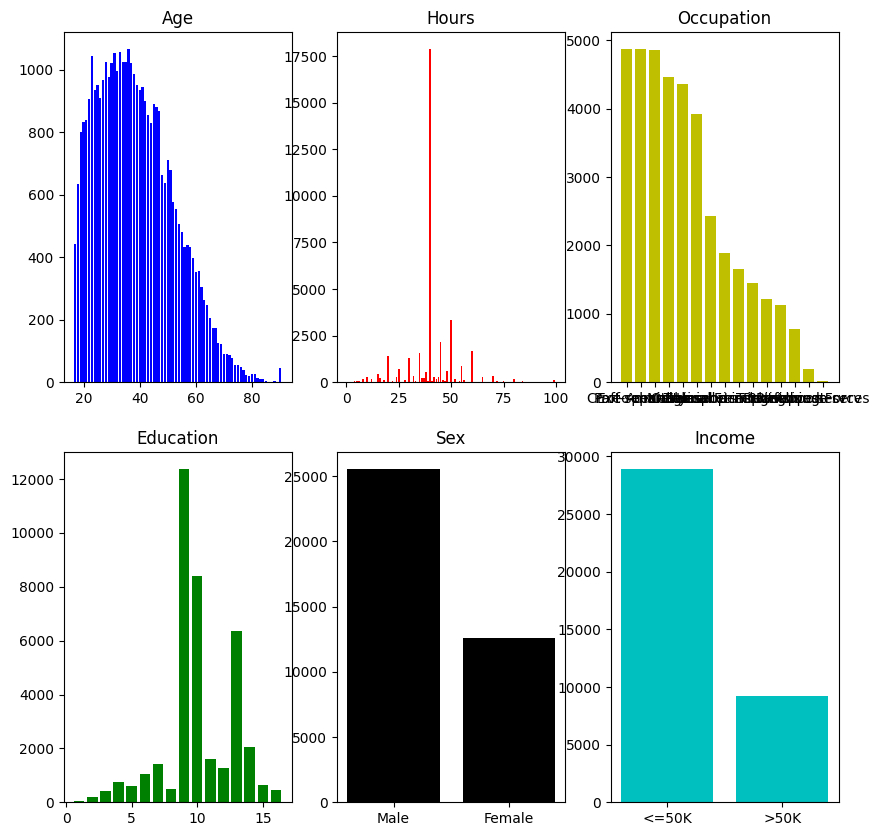

In [14]:
figure, axis = plt.subplots(2, 3,figsize=(10,10))

age_counts = X_train2['age'].value_counts()
axis[0,0].bar(age_counts.index, age_counts, color='b')
axis[0,0].set_title('Age')


hours_counts = X_train2['hours-per-week'].value_counts()
axis[0,1].bar(hours_counts.index, hours_counts, color='r')
axis[0,1].set_title('Hours')

ed_counts = X_train2['education-num'].value_counts()
axis[1,0].bar(ed_counts.index, ed_counts, color='g')
axis[1,0].set_title('Education')

sex_counts = X_train2['sex'].value_counts()
axis[1,1].bar(sex_counts.index, sex_counts, color='k')
axis[1,1].set_title('Sex')

oc_counts = X_train2['occupation'].value_counts()
axis[0,2].bar(oc_counts.index, oc_counts, color='y')
axis[0,2].set_title('Occupation')

y_counts = y_train2['income'].value_counts()
axis[1,2].bar(y_counts.index, y_counts, color='c')
axis[1,2].set_title('Income')

We see from the plots the data is fairly representative with age and hours per week, but a bit uneven for education, sex and income.

## Categories

Now we try to implement the Support Vector Machine. To proceed we first one hot encode the categorical variables. They have been extracted from the data below. 

In [15]:
categories = (X_train2.dtypes=='object')[(X_train2.dtypes=='object')==True].index
categories

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

As there is a numerical variable in the data representing education already, we can drop its categorical form from our analysis. We also drop the native country variable, as it contains many categories that would inflate the dimension of our data, and one can argue its information overlaps with the race variable. 

In [16]:
cat = list(categories)
cat.remove('education')
cat.remove('native-country')
cat

['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

In [17]:
X_train2.loc[:,cat]

,workclass,marital-status,occupation,relationship,race,sex
45492,Private,Divorced,Exec-managerial,Unmarried,White,Female
40885,Self-emp-not-inc,Married-civ-spouse,Farming-fishing,Husband,White,Male
35713,Private,Never-married,Other-service,Not-in-family,White,Male
26124,State-gov,Married-civ-spouse,Craft-repair,Husband,White,Male
15819,Private,Never-married,Farming-fishing,Own-child,White,Male
...,...,...,...,...,...,...
25544,Private,Married-civ-spouse,Machine-op-inspct,Husband,White,Male
48056,Local-gov,Married-civ-spouse,Prof-specialty,Husband,White,Male
11513,Private,Married-civ-spouse,Prof-specialty,Husband,White,Male
1688,Private,Divorced,Other-service,Not-in-family,White,Female


Next we have a look at the labels within each category.

In [18]:
for z in cat:
    print(X_train[z].unique())

['Private' 'Self-emp-not-inc' 'State-gov' '?' 'Self-emp-inc' 'Federal-gov'
 'Local-gov' nan 'Never-worked' 'Without-pay']
['Divorced' 'Married-civ-spouse' 'Never-married' 'Married-spouse-absent'
 'Widowed' 'Separated' 'Married-AF-spouse']
['Exec-managerial' 'Farming-fishing' 'Other-service' 'Craft-repair'
 'Prof-specialty' '?' 'Handlers-cleaners' 'Adm-clerical' 'Sales'
 'Transport-moving' 'Machine-op-inspct' 'Tech-support' 'Protective-serv'
 nan 'Priv-house-serv' 'Armed-Forces']
['Unmarried' 'Husband' 'Not-in-family' 'Own-child' 'Wife' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['Female' 'Male']


Irritatingly we see some ?s have creeped into workclass and occupation. Checking the labels from the data source (https://archive.ics.uci.edu/dataset/2/adult), we see no extra labels than the ones we have here, so we are unable to identify what the ?s represent. It is impossible to interpolate their values, and factors like occupation are arguably important so we cannot drop the variable as a whole. Therefore here it is decided to drop those rows as well.

In [19]:
a1 = X_train2[X_train2['workclass']=='?'].index
a2 = X_train2[X_train2['occupation']=='?'].index
print(a1)
print(a2)

Index([26373, 13949, 16004, 32093,   106,  3042,  2476,  2427,   792, 17811,
       ...
       31753, 14548, 25266,  4884,  1019, 18232, 20656, 24133,  6542, 11261],
      dtype='int64', length=1443)
Index([26373, 13949, 16004, 32093,   106,  3042,  2476,  2427,   792,  5361,
       ...
       31753, 14548, 25266,  4884,  1019, 18232, 20656, 24133,  6542, 11261],
      dtype='int64', length=1450)


In [20]:
qs = np.union1d(a1,a2)
len(qs)

1450

Again losing 1450 data points is not ideal but is possible given the size of the dataset. 

In [21]:
X_train2 = X_train2.drop(qs)
y_train2 = y_train2.drop(qs)

We now continue with the one hot encoding.

In [22]:
one_hot = pd.get_dummies(X_train2['workclass'])
for i in cat[1:]:
    d = pd.get_dummies(X_train2[i])
    one_hot = one_hot.join(d)

Next we remove the original categorical variables in the training set and replace them with the one hot vectors. We also note that the variable 'fnlwgt', according to sources online, gives the number of people each data point is thought to represent. This has no conceivable relevance to our classification problem but having the model fit around those numbers is likely to disrupt our analysis so we drop that as well.

In [23]:
X_train2 = X_train2.drop(categories,axis=1).join(one_hot)
X_train2 = X_train2.drop('fnlwgt',axis=1)
X_train2

,age,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,...,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Female,Male
45492,45,10,0,0,64,False,False,True,False,False,...,False,True,False,False,False,False,False,True,True,False
40885,32,7,0,0,80,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
35713,50,9,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,True
26124,43,9,0,0,40,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
15819,23,9,0,0,40,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25544,55,3,0,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,True
48056,55,13,0,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,True
11513,47,13,0,0,60,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,True
1688,53,5,0,0,36,False,False,True,False,False,...,False,False,False,False,False,False,False,True,True,False


## Support Vector Machine

With all the categories encoded we can now fit the SVM. This takes a bit of time to run.

In [24]:
fit = svm.SVC().fit(X_train2,y_train2.values.ravel())

Before we can apply this to our test data, we have to go through similar steps as above to remove inconsistencies. We change the discrepancy in income values:

In [25]:
r3 = y_test.loc[y_test["income"] == "<=50K."]
r4 = y_test.loc[y_test["income"] == ">50K."]
r3 = r3.index.values
r4 = r4.index.values
y_test.loc[r3] = "<=50K"
y_test.loc[r4] = ">50K"
y_test['income'].value_counts()

income
<=50K    7400
>50K     2369
Name: count, dtype: int64

Remove the ?s in the test data:

In [26]:
a3 = X_test[X_test['workclass']=='?'].index
a4 = X_test[X_test['occupation']=='?'].index
qs2 = np.union1d(a3,a4)
X_test2 = X_test.drop(qs2)
y_test2 = y_test.drop(qs2)

One hot encode the factors, attach it to the dataframe and drop the unneeded columns:

In [27]:
one_hot_test = pd.get_dummies(X_test2['workclass'])
for i in cat[1:]:
    d = pd.get_dummies(X_test2[i])
    one_hot_test = one_hot_test.join(d)

In [28]:
X_test2 = X_test2.drop(categories,axis=1).join(one_hot_test)
X_test2 = X_test2.drop('fnlwgt',axis=1)
X_test2

,age,education-num,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,...,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Female,Male
15241,40,8,0,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
21252,32,13,0,0,35,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
41097,37,9,0,1980,35,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,True
46926,27,13,0,0,50,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
29211,53,13,0,0,38,False,True,False,False,False,...,False,True,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14042,40,14,0,0,50,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
4578,48,11,0,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False
2448,29,9,0,0,40,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False
48258,17,6,0,0,25,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True


However it appears the test data has an extra category within workclass not present in the training data. As shown below there is only one such point, so removing it would not have an impact on our evaluation.

In [29]:
X_test2[X_test2['Never-worked']==True].index

Index([44168], dtype='int64')

In [30]:
X_test2 = X_test2.drop(44168)
y_test2 = y_test2.drop(44168)
X_test2 = X_test2.drop('Never-worked',axis=1)

In [31]:
test = fit.predict(X_test2)

In [32]:
metrics.accuracy_score(y_test2,test)

0.7941333333333334

We get an accuracy of 79.4%, which is not ideal but acceptable.

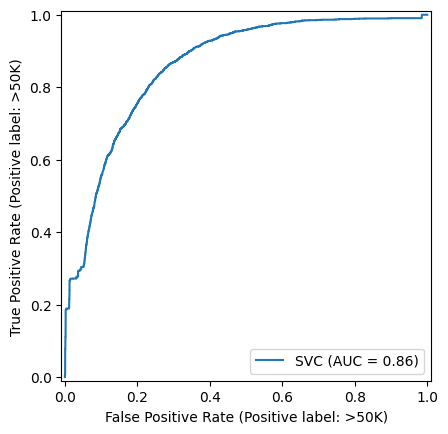

In [33]:
metrics.RocCurveDisplay.from_estimator(fit,X_test2,y_test2)

The ROC curve shows a similar result that we get a relatively large amount of false positives.

## Reduced Model

So far we have dropped a few variables that were clearly unnecessary. Looking at the columns, we see that it is not obvious what 'capital-gain' and 'capital-loss' represent. Even looking it up from the data source or related pages little elaboration is offered. As extra variables would make interpretation more difficult, we try to refit the model without them and see if the model suffers.

In [34]:
X_train3 = X_train2.drop('capital-gain',axis=1)
X_train3 = X_train3.drop('capital-loss',axis=1)
fit2 = svm.SVC().fit(X_train3,y_train2.values.ravel())

In [35]:
X_test3 = X_test2.drop('capital-gain',axis=1)
X_test3 = X_test3.drop('capital-loss',axis=1)
test2 = fit2.predict(X_test3)
metrics.accuracy_score(y_test2,test2)

0.8213333333333334

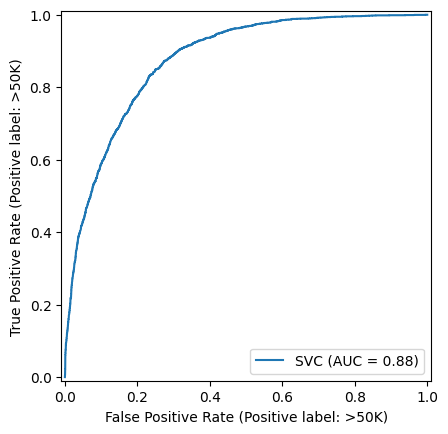

In [36]:
metrics.RocCurveDisplay.from_estimator(fit2,X_test3,y_test2)

Encouragingly we see it is more accurate than the previous model, and marginally outperforms it in the ROC curve. So this seems to be the better model to adopt. 

## Conclusion

In this report we looked at income data and tried to classify them into two groups. The SVM model used achieved a satisfactory accuracy as well as a decent ROC curve. We selected variables by intuitively considering whether they would be useful, and settled on a final model that includes all core factors that seemed useful, without excessive ones with little interpretive insight. From here one could carry out predictions the classes of new data, or perhaps analyse the fitted model to investigate the most influential factors that determine income. 

## References

https://scikit-learn.org/1.5/modules/svm.html

https://stackoverflow.com/questions/44931834/pandas-drop-function-error-label-not-contained-in-axis

https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected  

https://scikit-learn.org/1.5/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html

https://www.geeksforgeeks.org/determining-feature-importance-in-svm-classifiers-with-scikit-learn/